Similar to notebook [088] but using a single generator and compact syntax.

# Imports and Initialization

## Imports

In [1]:
from cbrain.climate_invariant import *
from cbrain.climate_invariant_utils import *
import pickle
#import h5netcdf
import time
import matplotlib as mpl

from cbrain.imports import *
from cbrain.utils import *
from cbrain.normalization import *

import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_memory_growth(physical_devices[1], True)
tf.config.experimental.set_memory_growth(physical_devices[2], True)

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

/nfspool-0/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog


## Initialization

In [2]:
path_data = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/'
path_array = {}

In [3]:
climate_str = ['cold','hot','both']
set_str = ['train','valid','test']
test_clim_str = ['cold','hot','both','medium']

In [4]:
path_array['cold'] = [path_data+'2021_03_18_O3_TRAIN_M4K_shuffle.nc',
                      path_data+'2021_03_18_O3_VALID_M4K.nc',
                      path_data+'2021_03_18_O3_TEST_M4K.nc']
path_array['hot'] = [path_data+'2021_03_18_O3_TRAIN_P4K_shuffle.nc',
                     path_data+'2021_03_18_O3_VALID_P4K.nc',
                     path_data+'2021_03_18_O3_TEST_P4K.nc']
path_array['both'] = [path_data+'2022_04_18_TRAIN_M4K_P4K_shuffle.nc',
                      path_data+'2022_04_18_VALID_M4K_P4K.nc',
                      path_data+'2022_04_18_TEST_M4K_P4K.nc']
path_array['medium'] = [path_data+'2021_01_24_O3_TRAIN_shuffle.nc',
                        path_data+'2021_01_24_O3_VALID.nc',
                        path_data+'2021_01_24_O3_TEST.nc']

In [5]:
path_input_norm = path_data + '2021_01_24_NORM_O3_small.nc'
path_norm_RH = path_data + '2021_02_01_NORM_O3_RH_small.nc'
path_norm_BMSE = path_data + '2021_06_16_NORM_BMSE_small.nc'
path_norm_LHF_nsDELQ = path_data + '2021_02_01_NORM_O3_LHF_nsDELQ_small.nc'

In [6]:
in_vars = ['QBP','TBP','PS','SOLIN','SHFLX','LHFLX'] # We take the large-scale climate state as inputs
out_vars = ['PHQ','TPHYSTND','QRL','QRS'] # and we output the response of clouds/storms to these climate conditions

In [7]:
scale_dict = pickle.load(open(path_data+'009_Wm2_scaling.pkl','rb'))

In [8]:
fz = 12
lw = 2
siz = 100

plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw

# Data Generators

## First, define generators necessary for rescaling

In [9]:
def train_gen_rescaling(input_rescaling):
    return DataGeneratorCI(
        data_fn = path_array['cold'][0],
        input_vars = input_rescaling,
        output_vars = out_vars,
        norm_fn = path_input_norm,
        input_transform = ('mean', 'maxrs'),
        output_transform = scale_dict)

In [10]:
train_gen_RH = train_gen_rescaling(in_vars)
train_gen_BMSE = train_gen_rescaling(in_vars)
train_gen_LHF_nsDELQ = train_gen_rescaling(in_vars)

## Then, generate structure containing all data generators

In [11]:
def Generator_singleDS(path,rescaling=None):
    
    in_vars = ['QBP','TBP','PS','SOLIN','SHFLX','LHFLX'] # We take the large-scale climate state as inputs
    out_vars = ['PHQ','TPHYSTND','QRL','QRS'] # and we output the response of clouds/storms to these climate conditions
    path_input_norm = path_data + '2021_01_24_NORM_O3_small.nc'
    scale_dict = pickle.load(open(path_data+'009_Wm2_scaling.pkl','rb'))
    
    if rescaling=='CI':
        gen = DataGeneratorCI(
        data_fn = path,
        input_vars = in_vars,
        output_vars = out_vars,
        norm_fn = path_input_norm,
        batch_size=8192,
        input_transform = ('mean', 'maxrs'),
        output_transform = scale_dict,
        Qscaling = 'RH',
        Tscaling = 'BMSE',
        LHFscaling = 'LHF_nsDELQ',
        hyam=hyam, hybm=hybm, # Arrays to define mid-levels of hybrid vertical coordinate
        inp_sub_Qscaling=train_gen_RH.input_transform.sub, # What to subtract from RH inputs
        inp_div_Qscaling=train_gen_RH.input_transform.div, # What to divide RH inputs by
        inp_sub_Tscaling=train_gen_BMSE.input_transform.sub,
        inp_div_Tscaling=train_gen_BMSE.input_transform.div,
        inp_sub_LHFscaling=train_gen_LHF_nsDELQ.input_transform.sub,
        inp_div_LHFscaling=train_gen_LHF_nsDELQ.input_transform.div
        ) 
    else:
        gen = DataGeneratorCI(
        data_fn = path,
        input_vars = in_vars,
        output_vars = out_vars,
        norm_fn = path_input_norm,
        batch_size=8192,
        input_transform = ('mean', 'maxrs'),
        output_transform = scale_dict
        )

    return gen 

In [12]:
BFgen = {}
CIgen = {}

In [13]:
for iclimate,clim in enumerate(test_clim_str):
    print('Climate = ',clim)
    BFgen[clim] = {}
    CIgen[clim] = {}
    
    for iset,st in enumerate(set_str):
        print('Set = ',st)
        
        BFgen[clim][st] = Generator_singleDS(path_array[clim][iset])
        CIgen[clim][st] = Generator_singleDS(path_array[clim][iset],rescaling='CI')

Climate =  cold
Set =  train
Set =  valid
Set =  test
Climate =  hot
Set =  train
Set =  valid
Set =  test
Climate =  both
Set =  train
Set =  valid
Set =  test
Climate =  medium
Set =  train
Set =  valid
Set =  test


# Models

## Varying depth

In [13]:
N_layer_max = 10

In [14]:
def NN_model(inp,N_layer):
    if N_layer>0:
        densout = Dense(128, activation='linear')(inp)
        densout = LeakyReLU(alpha=0.3)(densout)
    else: dense_out = Dense(120, activation='linear')(inp)
    for i in range (N_layer-1):
        densout = Dense(128, activation='linear')(densout)
        densout = LeakyReLU(alpha=0.3)(densout)
    if N_layer>0: dense_out = Dense(120, activation='linear')(densout)
    return tf.keras.models.Model(inp, dense_out)

In [15]:
BF_models = {}
CI_models = {}
inp_BF = {}
inp_CI = {}

In [16]:
for ilayer in range(N_layer_max):
    
    print(ilayer)
    
    inp_BF[ilayer] = Input(shape=(64,))
    BF_models[ilayer] = NN_model(inp_BF[ilayer],ilayer)
    
    inp_CI[ilayer] = Input(shape=(64,))
    CI_models[ilayer] = NN_model(inp_CI[ilayer],ilayer)

0
1
2
3
4
5
6
7
8
9


In [17]:
for ilayer in range(N_layer_max):
    
    print(ilayer)
    
    BF_models[ilayer].compile(tf.keras.optimizers.Adam(), loss=mse)
    CI_models[ilayer].compile(tf.keras.optimizers.Adam(), loss=mse)

0
1
2
3
4
5
6
7
8
9


## Varying Width

In [13]:
Max_width = 5

In [28]:
def NN_model(inp,width):
    densout = Dense((2**(8+width)), activation='linear')(inp)
    densout = LeakyReLU(alpha=0.3)(densout)
    dense_out = Dense(120, activation='linear')(densout)
    return tf.keras.models.Model(inp, dense_out)

In [29]:
BF_models = {}
CI_models = {}
inp_BF = {}
inp_CI = {}

In [30]:
for width in range(Max_width):
    
    print(width)
    
    inp_BF[width] = Input(shape=(64,))
    BF_models[width] = NN_model(inp_BF[width],width)
    
    inp_CI[width] = Input(shape=(64,))
    CI_models[width] = NN_model(inp_CI[width],width)

0
1
2
3
4


In [31]:
for width in range(Max_width):
    
    print(width)
    
    BF_models[width].compile(tf.keras.optimizers.Adam(), loss=mse)
    CI_models[width].compile(tf.keras.optimizers.Adam(), loss=mse)

0
1
2
3
4


In [33]:
BF_models[4].summary()

Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 64)]              0         
_________________________________________________________________
dense_56 (Dense)             (None, 4096)              266240    
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 4096)              0         
_________________________________________________________________
dense_57 (Dense)             (None, 120)               491640    
Total params: 757,880
Trainable params: 757,880
Non-trainable params: 0
_________________________________________________________________


# Callbacks

In [34]:
class AdditionalValidationSets(Callback):
    def __init__(self, validation_sets, verbose=0, batch_size=None):
        """
        :param validation_sets:
        a list of 3-tuples (validation_data, validation_targets, validation_set_name)
        or 4-tuples (validation_data, validation_targets, sample_weights, validation_set_name)
        :param verbose:
        verbosity mode, 1 or 0
        :param batch_size:
        batch size to be used when evaluating on the additional datasets
        """
        super(AdditionalValidationSets, self).__init__()
        self.validation_sets = validation_sets
        self.epoch = []
        self.history = {}
        self.verbose = verbose
        self.batch_size = batch_size

    def on_train_begin(self, logs=None):
        self.epoch = []
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epoch.append(epoch)

        # record the same values as History() as well
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        # evaluate on the additional validation sets
        for validation_set in self.validation_sets:
            valid_generator,valid_name = validation_set
            results = self.model.evaluate_generator(generator=valid_generator)

            for metric, result in zip(self.model.metrics_names,[results]):
                valuename = valid_name + '_' + metric
                self.history.setdefault(valuename, []).append(result)

In [35]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

# Training on both datasets at once

In [36]:
Nep = 20

In [37]:
history_BF = {}
history_CI = {}

In [38]:
# for ilayer in range(N_layer_max):
    
#     print('Number of layers = ',ilayer)
    
#     path_BF = path_data + '2022_04_18_BF_'+str(ilayer)+'.hdf5'
#     mcp_save = ModelCheckpoint(path_BF,save_best_only=True, monitor='val_loss', mode='min')
#     history_BF[ilayer] = BF_models[ilayer].fit_generator(BFgen['both']['train'],epochs=Nep, 
#                                                          validation_data = BFgen['both']['valid'],
#                                                          callbacks=[mcp_save,earlyStopping])
    
#     path_CI = path_data + '2022_04_18_CI_'+str(ilayer)+'.hdf5'
#     mcp_save = ModelCheckpoint(path_CI,save_best_only=True, monitor='val_loss', mode='min')
#     history_CI[ilayer] = CI_models[ilayer].fit_generator(CIgen['both']['train'],epochs=Nep, 
#                                                          validation_data = CIgen['both']['valid'],
#                                                          callbacks=[mcp_save,earlyStopping])

In [ ]:
for width in range(Max_width):
    
    print('width = ',width)
    
    path_BF = path_data + '2022_04_24_BF_'+str(width)+'.hdf5'
    mcp_save = ModelCheckpoint(path_BF,save_best_only=True, monitor='val_loss', mode='min')
    history_BF[width] = BF_models[width].fit_generator(BFgen['both']['train'],epochs=Nep, 
                                                       validation_data = BFgen['both']['valid'],
                                                       callbacks=[mcp_save,earlyStopping])
    
    path_CI = path_data + '2022_04_24_CI_'+str(width)+'.hdf5'
    mcp_save = ModelCheckpoint(path_CI,save_best_only=True, monitor='val_loss', mode='min')
    history_CI[width] = CI_models[width].fit_generator(CIgen['both']['train'],epochs=Nep, 
                                                       validation_data = CIgen['both']['valid'],
                                                       callbacks=[mcp_save,earlyStopping])

width =  0
Epoch 1/20
11518/11518 [==============================] - 1189s 103ms/step - loss: 413.0041 - val_loss: 380.1686
Epoch 2/20
11518/11518 [==============================] - 1162s 101ms/step - loss: 367.9527 - val_loss: 364.2285
Epoch 3/20
11518/11518 [==============================] - 1199s 104ms/step - loss: 355.8919 - val_loss: 354.8779
Epoch 4/20
11518/11518 [==============================] - 1142s 99ms/step - loss: 348.3158 - val_loss: 348.5552
Epoch 5/20
11518/11518 [==============================] - 1178s 102ms/step - loss: 342.6271 - val_loss: 344.0391
Epoch 6/20
11518/11518 [==============================] - 2061s 179ms/step - loss: 338.0932 - val_loss: 338.8907
Epoch 7/20
11518/11518 [==============================] - 1668s 145ms/step - loss: 334.5029 - val_loss: 335.6415
Epoch 8/20
11518/11518 [==============================] - 1164s 101ms/step - loss: 331.5970 - val_loss: 332.6764
Epoch 9/20
11518/11518 [==============================] - 1215s 106ms/step - loss: 329

In [ ]:
path_history = path_data + 'PKL_DATA/2022_04_24_Train_Both_Datasets'

In [ ]:
# pickle.dump({'history_BF':history_BF,'history_CI':history_CI},
#             open(path_history,'wb'))

# Evaluate as fx of width in each climate separately

## Calculate performance on test dataset of each climate

In [14]:
Max_width = 5
st = 'test'

In [15]:
BFtest = {}; CItest = {}

In [18]:
for iclimate,clim in enumerate(test_clim_str):
    print('Climate = ',clim)
    BFtest[clim] = {}; CItest[clim] = {}
    
    BFg = BFgen[clim][st]; CIg = CIgen[clim][st]
    
    for width in range(Max_width):
        print('width = ',width)
    
        path_BF = path_data + '2022_04_24_BF_'+str(width)+'.hdf5'
        path_CI = path_data + '2022_04_24_CI_'+str(width)+'.hdf5'
        BFNN = tf.keras.models.load_model(path_BF)
        CINN = tf.keras.models.load_model(path_CI)
    
        BFtest[clim][width] = BFNN.evaluate_generator(BFg)
        CItest[clim][width] = CINN.evaluate_generator(CIg)

Climate =  cold
width =  0
width =  1
width =  2
width =  3
width =  4
Climate =  hot
width =  0
width =  1
width =  2
width =  3
width =  4
Climate =  both
width =  0
width =  1
width =  2
width =  3
width =  4
Climate =  medium
width =  0
width =  1
width =  2
width =  3
width =  4


In [19]:
path_test = path_data + 'PKL_DATA/2022_05_02_Performance_Four_Climates_Width'

In [20]:
# pickle.dump({'BFtest':BFtest,'CItest':CItest},
#             open(path_test,'wb'))

## Plots

In [21]:
path_test = path_data + 'PKL_DATA/2022_05_02_Performance_Four_Climates_Width'
Performance = pickle.load(open(path_test,'rb'))

In [22]:
BFtest = Performance['BFtest']
CItest = Performance['CItest']

In [23]:
for key in BFtest.keys():
    BFtest[key]['plot'] = np.zeros((5,))
    CItest[key]['plot'] = np.zeros((5,))
    for i in range(5):
        BFtest[key]['plot'][i] = BFtest[key][i]
        CItest[key]['plot'][i] = CItest[key][i]

In [24]:
color_array = ['blue','red','black','gray']

Text(0, 0.5, 'Mean-squared error')

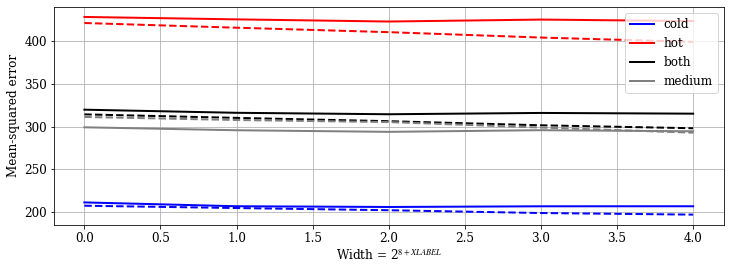

In [28]:
fig = plt.figure(figsize=(12,4))
ax = plt.gca()

ikey = 0
for key in BFtest.keys():
    plt.plot(CItest[key]['plot'],label=key,color=color_array[ikey])
    plt.plot(BFtest[key]['plot'],linestyle='--',color=color_array[ikey])
    ikey += 1
    
plt.legend()
plt.grid()
plt.xlabel('Width = 2$^{8+XLABEL}$')
plt.ylabel('Mean-squared error')